## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](example.png)

### Load and preprocess data

Script `get_data.py` unpacks data — images and labelled points. 6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file. Run the cell below to unpack data.

In [2]:
# from get_data import unpack
# unpack('facial-keypoints-data.zip')

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [1]:
import pandas as pd
import gc

df = pd.read_csv('data/gt.csv')

df.head()

,filename,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14
0,00000.jpg,51,51,127,60,169,65,203,52,68,...,193,84,156,144,92,174,140,180,168,179
1,00001.jpg,21,20,36,18,57,19,80,25,23,...,78,33,43,46,31,61,45,66,60,65
2,00002.jpg,23,116,39,83,47,57,56,19,36,...,62,31,91,86,106,122,115,100,121,81
3,00003.jpg,29,18,63,25,84,32,105,34,38,...,95,45,72,71,46,83,63,87,75,89
4,00004.jpg,31,53,76,44,107,38,136,33,40,...,129,49,111,105,72,137,106,132,126,121


In [2]:
### Useful routines for preparing data
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt 
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize


def load_imgs_and_keypoints(dirname='data/images'):
    # Write your code for loading images and points here
    df = pd.read_csv('data/gt.csv')
    imgs, points = [], []
    for i, row in df.iterrows():    
        img = cv2.imread(os.path.join('data/images', row.filename), 1)[:,:,::-1]
        x = np.array(row.drop('filename'))[::2] / img.shape[1] - 0.5
        y = np.array(row.drop('filename'))[1::2] / img.shape[0] - 0.5
        points.append(np.stack([x, y], axis=1).ravel().astype(np.float32))
        imgs.append(resize(img, [100, 100, 3]))
    return np.array(imgs), np.array(points)

imgs, points = load_imgs_and_keypoints()

In [66]:
points.shape, imgs.shape

((6000, 28), (6000, 100, 100, 3))

array([-0.3053435 , -0.3053435 , -0.01526718, -0.27099237,  0.14503817,
       -0.2519084 ,  0.27480915, -0.30152673, -0.24045801, -0.20610687,
       -0.17557251, -0.21374045, -0.08015267, -0.1870229 ,  0.11068702,
       -0.16793893,  0.15267175, -0.19847329,  0.23664123, -0.17938931,
        0.09541985,  0.04961832, -0.14885496,  0.16412213,  0.03435114,
        0.1870229 ,  0.14122137,  0.18320611], dtype=float32)

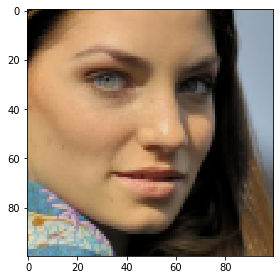

In [3]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[0])
points[0]

### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

In [15]:
import matplotlib.pyplot as plt
# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle

def visualize_points(img, points):
    # Write here function which obtains image and normalized
    # coordinates and visualizes points on image
    imshow(img)
    x, y = points[::2], points[1::2]
    plt.scatter((x + 0.5) * 100, (y + 0.5) * 100)
    for i in range(len(points) // 2):
        plt.annotate(str(i), ((points[i * 2] + 0.5) * 100, (points[i * 2 + 1] + 0.5) * 100))
    
# visualize_points(imgs[1], points[1])

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [5]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

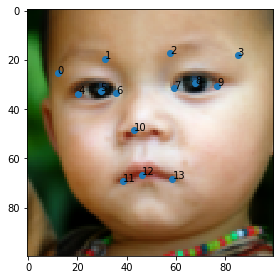

In [28]:
def swap_els(arr, id1, id2):
    arr[id1 * 2], arr[id2 * 2] = arr[id2 * 2], arr[id1 * 2]
    arr[id1 * 2 + 1], arr[id2 * 2 + 1] = arr[id2 * 2 + 1], arr[id1 * 2 + 1]
    return arr

def flip_img(img, points):
    # Write your code for flipping here
    x, y = points[::2], points[1::2]
    f_points = np.stack([-x, y], axis=1).ravel()
    f_points = swap_els(f_points, 0, 3)
    f_points = swap_els(f_points, 1, 2)
    f_points = swap_els(f_points, 4, 9)
    f_points = swap_els(f_points, 5, 8)
    f_points = swap_els(f_points, 6, 7)
    f_points = swap_els(f_points, 11, 13)
    return cv2.flip(img, 1), f_points

f_img, f_points = flip_img(imgs_train[1], points_train[1])
visualize_points(f_img, f_points)

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [29]:
# Write your code here
aug_imgs_train, aug_points_train = [], []
for img, point_s in zip(imgs_train, points_train):
    aug_imgs_train.append(img)
    aug_points_train.append(point_s)
    f_img, f_points = flip_img(img, point_s)
    aug_imgs_train.append(f_img)
    aug_points_train.append(f_points)

aug_imgs_train, aug_points_train = np.array(aug_imgs_train), np.array(aug_points_train)

In [30]:
aug_imgs_train.shape, aug_points_train.shape

((10800, 100, 100, 3), (10800, 28))

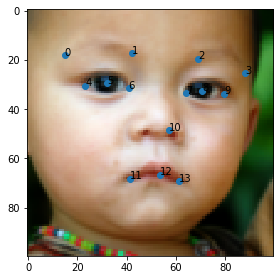

In [31]:
visualize_points(aug_imgs_train[2], aug_points_train[2])

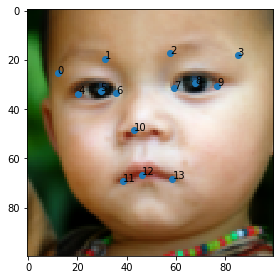

In [32]:
visualize_points(aug_imgs_train[3], aug_points_train[3])

In [10]:
del imgs
del points
gc.collect()

7638

### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [67]:
from keras.models import Sequential
from keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout
)

model = Sequential([
        Input(shape=(100, 100, 3)),
        Conv2D(32, kernel_size=(3, 1)),
        Conv2D(32, kernel_size=(1, 3), activation="relu"),
        MaxPooling2D(),
        Conv2D(64, kernel_size=(3, 1)),
        Conv2D(64, kernel_size=(1, 3), activation="relu"),
        MaxPooling2D(),
        Conv2D(128, kernel_size=(3, 1)),
        Conv2D(128, kernel_size=(1, 3), activation="relu"),
        MaxPooling2D(),
        Conv2D(256, kernel_size=(3, 1)),
        Conv2D(256, kernel_size=(1, 3), activation="relu"),
        MaxPooling2D(),
        Flatten(),
        Dense(1000, activation="relu", name="layer3"),
        Dropout(0.3),
        Dense(100, activation="relu", name="layer4"),
        Dropout(0.3),
        Dense(28, name="layer5"),
    ])

In [68]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 98, 100, 32)       320       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 98, 98, 32)        3104      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 47, 49, 64)        6208      
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 47, 47, 64)        12352     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 21, 23, 128)      

Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [69]:
# ModelCheckpoint can be used for saving model during training.
# Saved models are useful for finetuning your model 
# See keras documentation for more info
from keras.callbacks import ModelCheckpoint
# from keras.optimizers import SGD, Adam

# Choose optimizer, compile model and run training
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = ModelCheckpoint(checkpoint_filepath, monitor='val_mse', verbose=1,
    save_best_only=True, mode='min', save_freq='epoch')

# The model weights (that are considered the best) are loaded into the model.
# model.load_weights(checkpoint_filepath)

In [64]:
from sklearn.utils import shuffle

aug_imgs_train_shuf, aug_points_train_shuf = shuffle(aug_imgs_train, aug_points_train, random_state=42)

In [65]:
del aug_imgs_train
del aug_points_train
gc.collect();

In [70]:
EPOCHS = 5
model.fit(aug_imgs_train_shuf, aug_points_train_shuf,
          epochs=EPOCHS,
          callbacks=[model_checkpoint_callback],
          validation_data=(imgs_val, points_val))

Epoch 1/5
338/338 [==============================] - 172s 507ms/step - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0029 - val_mse: 0.0029

Epoch 00001: val_mse improved from inf to 0.00292, saving model to ./tmp/checkpoint
INFO:tensorflow:Assets written to: ./tmp/checkpoint/assets
Epoch 2/5
338/338 [==============================] - 148s 436ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0016 - val_mse: 0.0016

Epoch 00002: val_mse improved from 0.00292 to 0.00161, saving model to ./tmp/checkpoint
INFO:tensorflow:Assets written to: ./tmp/checkpoint/assets
Epoch 3/5
338/338 [==============================] - 148s 439ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0013 - val_mse: 0.0013

Epoch 00003: val_mse improved from 0.00161 to 0.00134, saving model to ./tmp/checkpoint
INFO:tensorflow:Assets written to: ./tmp/checkpoint/assets
Epoch 4/5
338/338 [==============================] - 134s 396ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0011 - val_mse: 0.0011

Epoch 00004: val_ms

### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

In [71]:
preds = model.predict(imgs_val)

In [54]:
preds.shape

(600, 28)

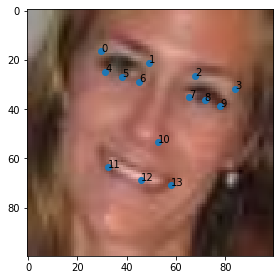

In [84]:
visualize_points(imgs_val[7], preds[7])

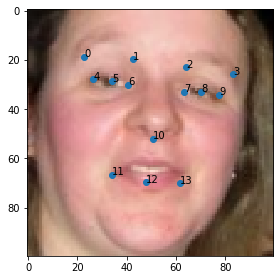

In [92]:
visualize_points(imgs_val[17], preds[17])

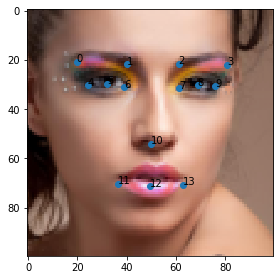

In [93]:
visualize_points(imgs_val[237], preds[237])